In [2]:
# !conda install -c conda-forge librosa

# !conda install tqdm

import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import utils
reload(utils)
import hyperparams
reload(hyperparams)
import datasets
reload(datasets)
import dcttsModel
reload(dcttsModel)

<module 'dcttsModel' from '/home/aduriseti/tts/ettts_master/dcttsModel.py'>

In [3]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [4]:
# params = hyperparams.Hyperparams()
ssrnParams = hyperparams.Hyperparams(sep=1,pad=None,chunk=None)
text2MelParams = hyperparams.Hyperparams(sep=0,pad=2)
ssrn = dcttsModel.SSRN(ssrnParams).to(dev)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)

# print tunable hyperparams
print('TEXT2MEL HYPERPARAMS',text2MelParams.paramDict)
print('SSRN HYPERPARAMS',ssrnParams.paramDict)
[sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,ssrn)]


TEXT2MEL HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 2, 'reversedDilation': 0}
SSRN HYPERPARAMS {'sep': 1, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'reversedDilation': 0}


[23970288, 24991247]

In [5]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A,I):
        b,N,T = A.shape
#         assert I.shape == (b,)
# #         print(I)
# #         print(sum(I).shape,sum(I))
#         if ch.sum(I):
        if text2MelParams.pad == 2:
#             print('SLOW')
            W = ch.Tensor([[[np.e**(-(n/N-(t-i)/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)]
                           for i in range(b)])
        else:
#             print('FAST')
            W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)])
#         W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*text2MelParams.g**2)) 
#                              for t in range(1,T+1)] 
#                             for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()



L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def MelFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [6]:
def text2MelLossFun(text2Mel,batch):
    bL,bS,_,bI = batch
    Shat,A = text2Mel(bL,bS)
    melLoss = MelFun(Shat[:,:,:-text2Mel.params.chunk],bS[:,:,text2Mel.params.chunk:])
#     print(bI)
    attLoss = GAttFun(A,bI)
    return melLoss + attLoss

def text2MelDispFun(text2Mel,batch):
#     bL,bS,bY,bI = batch
    bL,bS,bY,i = [t[0:1] for t in batch] # only use first element of batch
    print([bL.shape,bS.shape,bY.shape,i.shape])
    print('LOSS:',text2MelLossFun(text2Mel,batch).item())
    Shat,A = text2Mel(bL,bS)
    bL,bS,Shat,A,bY,i = [t[0].cpu().detach().numpy() for t in (bL,bS,Shat,A,bY,i)]
    print('PAD INDEX',i)
    print('TEXT',"".join(text2Mel.params.i2c[c] for c in bL))
    plt.imshow(bS,cmap='gray')
    plt.show()
    plt.imshow(Shat,cmap='gray')
    plt.show()
    plt.imshow(A,cmap='gray')
    plt.show()

In [7]:
# nWorkers = 8 if ch.cuda.is_available() else 0
nWorkers = 6 if ch.cuda.is_available() else 0
text2MelParams = hyperparams.Hyperparams(sep=0,pad=0)
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1,params=text2MelParams),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)
text2MelOpt = ch.optim.Adam(text2Mel.parameters(),lr=text2MelParams.lr,
                            betas=(text2MelParams.b1,text2MelParams.b2),
                            eps=text2MelParams.eps)

In [8]:
# for batch in tqdm.tqdm_notebook(text2MelLoader):
#     pass

In [9]:
text2MelWrapper = utils.ModelWrapper(network=text2Mel,optimizer=text2MelOpt,
                                     lossFun=text2MelLossFun,loader=text2MelLoader,
                                     modelName='text2Mel',dev=dev,dispFun=text2MelDispFun)

INITIALIZED text2Mel WITH HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 0, 'reversedDilation': 0}
TOTAL PARAM COUNT 23970288


In [ ]:
text2MelWrapper.train(numEpochs=200)

EPOCH 0


In [80]:
# text2MelWrapper.load()
# text2MelWrapper.disp()

In [84]:
# text2MelParams = hyperparams.Hyperparams(sep=0,pad=2)
# text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1,params=text2MelParams),
#                                  batch_size=16,
#                                  shuffle=True,
#                                  num_workers=nWorkers)
# text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)
# text2MelOpt = ch.optim.Adam(text2Mel.parameters(),lr=text2MelParams.lr,
#                             betas=(text2MelParams.b1,text2MelParams.b2),
#                             eps=text2MelParams.eps)
# text2MelWrapper = utils.ModelWrapper(network=text2Mel,optimizer=text2MelOpt,
#                                      lossFun=text2MelLossFun,loader=text2MelLoader,
#                                      modelName='text2Mel',dev=dev,dispFun=text2MelDispFun)
# text2MelWrapper.train(numEpochs=1)
# text2MelWrapper.disp(k=5)

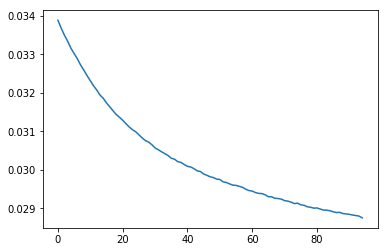

In [30]:
plt.plot(text2MelWrapper.lossHist[5:])

In [ ]:
import datasets
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)

ssrn = dcttsModel.SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)

ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 1
if load:
    startEpoch,lossHist,bestLoss = utils.loadChkpt(ssrn,ssrnOpt,'ssrn',dev)
else:
    # COLD START - RESET SSRN
    print('COLD START')
    print('HYPERPARAMS',utils.paramDict)
    ssrn = dcttsModel.SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
    ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')